# 17-6. 프로젝트 - Movielens 영화 SBR

### [루브릭]
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
    - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
    
    
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
    - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
    
    
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
    - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


### [학습과정]
1. 데이터의 전처리
2. 미니 배치의 구성
3. 모델 구성
4. 모델 학습
5. 모델 테스트


### [결론 및 회고]

## 1. 데이터의 전처리
### 1-1. Data Load

In [1]:
import os
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/E17_SessionBasedRecommendation/data/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486



유저ID 수와 아이템ID 수를 확인해봅니다. 유저ID가 6040개, 아이템ID는 3706개가 있습니다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 2-2. Session Length

In [4]:
user_length = data.groupby('UserId').size()   # 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.median(), user_length.mean()   # 평균 한 유저ID 당 약 165개 평점을 남김, 중앙값은 96개

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()  # 최소 20개, 최대 2314개

(20, 2314)

In [7]:
user_length.quantile(0.999)           # 99.9%의 유저들은 1343개 이하의 rating을 가지고 있습니다.

1343.181000000005

In [8]:
user_length.quantile(0.9999) 

2033.790399999547

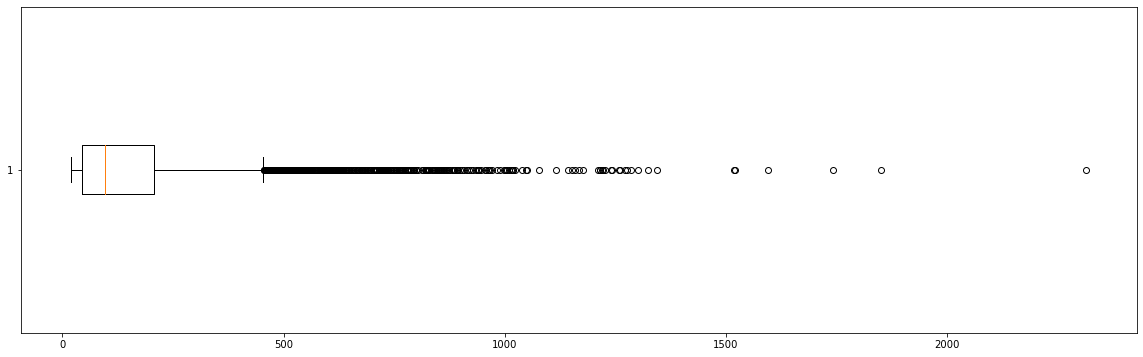

In [9]:
plt.figure(figsize=(20,6))
plt.boxplot(user_length, vert=0)
plt.show()

In [10]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

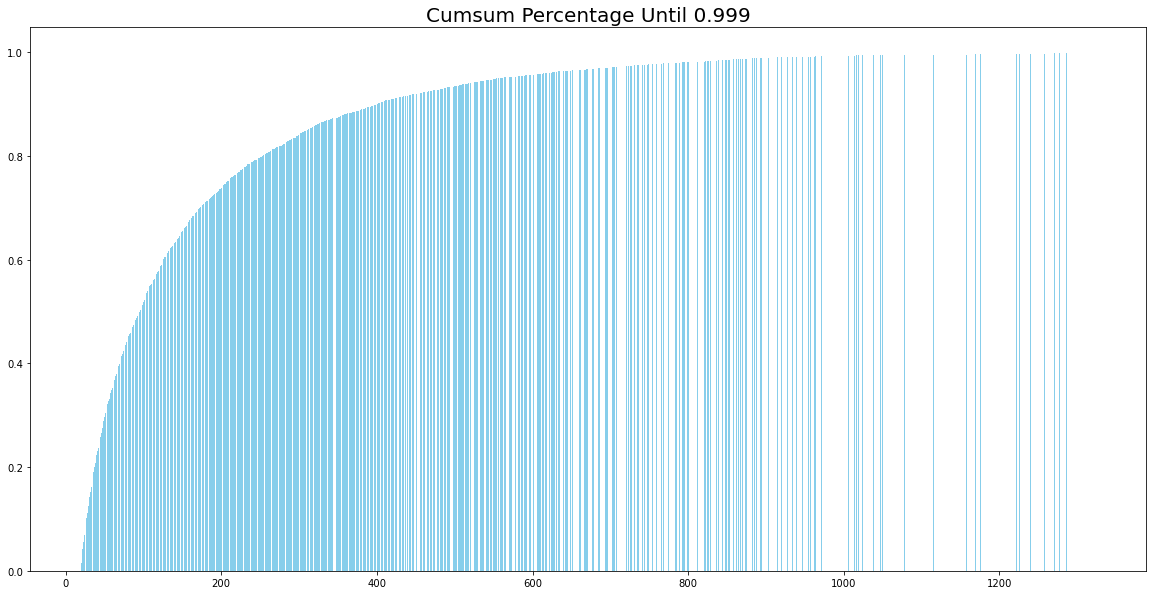

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='skyblue')
#plt.xticks(length_percent_cumsum_999.index)
#plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

데이터를 보니 일단 99.9%의 User가 남긴 평점 데이터는
* 20부터 약 1400까지 그 스펙트럼이 매우 넓고
* 그 값들이 매우 다양함을 볼 수 있습니다.


In [12]:
# 어떤 영화에 세션 수가 많은지 보겠습니다
mv_count = data.groupby('ItemId')['UserId'].count()
mv_count.sort_values(ascending=False).head(10)

ItemId
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
Name: UserId, dtype: int64

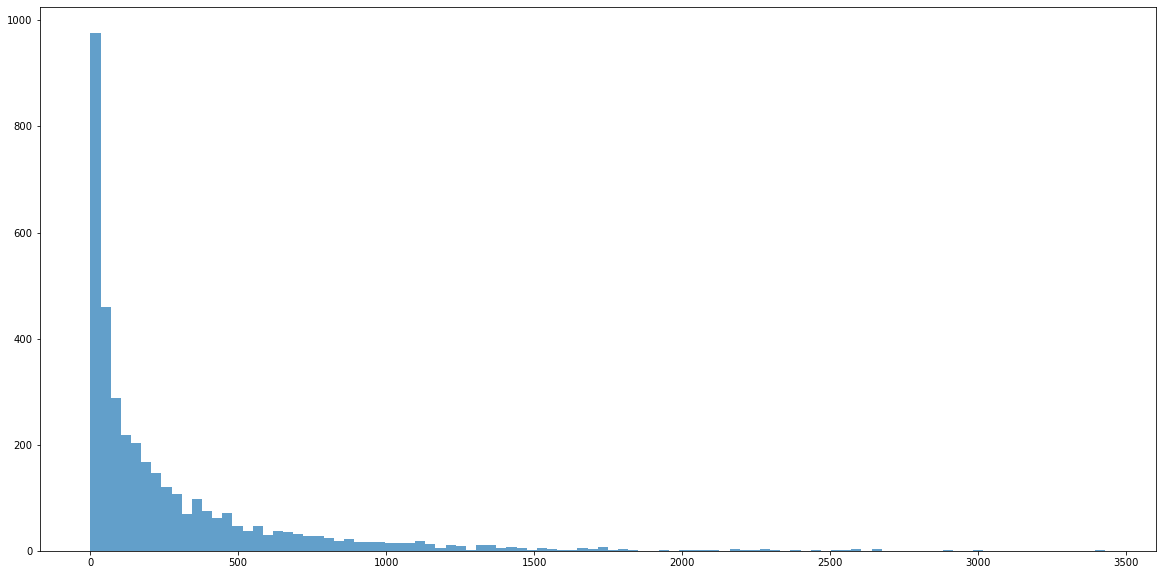

In [13]:
plt.figure(figsize=(20,10))
plt.hist(mv_count, bins=100, density=False, alpha=0.7, histtype='stepfilled')
plt.show()

평점이 100개 이내인 영화가 거의 대부분입니다. 개수 자체는 선호도와 연관이 크게 없는 것 같습니다. 

In [14]:
long_rating = user_length[user_length==2314].index[0]
data[data['UserId']==long_rating]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


유저 아이디 4169 얘는 뭔데 영화 평점을 2314개나 남긴거지..   
근데 boxplot을 보니 1000개 이상 데이터를 남긴 사람도 은근히 있다. 그럼 2000개 넘게 남긴 것도 그렇게 이상하지 않은거 아닐까?
그치만 세션 길이 2000이 넘는 것은 boxplot 상의 이상치들 중에서도 매우 멀리 떨어져 있기도 하고   
평점을 남긴 시간대를 보면 초까지 똑같은 시간에 남겼다는게 말이 안되기 때문에 뒤에서 얘는 지우겠습니다. 


Time을 살펴보겠습니다.

### 2-3. Session Time

In [15]:
import datetime

In [16]:
# 우선 Time 컬럼이 보기가 힘드니 Date 로 바꿔서 보겠습니다

dt = datetime.datetime.strptime('1970-01-01', '%Y-%m-%d')
tmp = data['Time']
datatime = []
for i in tmp:
    date = dt + datetime.timedelta(seconds= i)
    tmp = date.strftime('%Y-%m-%d')
    datatime.append(tmp)

data['Date'] = datatime

In [17]:
data

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [18]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25
2003-02-28


In [19]:
# 2000년 4월부터 2003년 2월까지의 데이터임을 알 수 있습니다. 

In [20]:
yr2000 = data[data['Date'].str.contains('2000')]
yr2001 = data[data['Date'].str.contains('2001')]
yr2002 = data[data['Date'].str.contains('2002')]
yr2003 = data[data['Date'].str.contains('2003')]

In [21]:
print(len(yr2000))
print(len(yr2001))
print(len(yr2002))
print(len(yr2003))

904757
68058
24046
3348


In [22]:
# 시간 흐름에 따른 영화 선호 함 보기
# 전체 기간에서 평점이 많이 남겨진 영화

In [23]:
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

1점인 영화는 선호하는 영화에서 거리가 머니 나중에 제거해주겠습니다. 

In [24]:
# 2000년도에 가장 인기있는 영화는?
mv_count0 = yr2000.groupby('ItemId')['UserId'].count()
mv_count0.sort_values(ascending=False).head(10)

ItemId
2858    3291
1196    2846
260     2834
1210    2772
480     2559
589     2547
2028    2538
1270    2448
2571    2446
1580    2433
Name: UserId, dtype: int64

In [25]:
# 2001년도에 가장 인기있는 영화는?
mv_count1 = yr2001.groupby('ItemId')['UserId'].count()
mv_count1.sort_values(ascending=False).head(10)

ItemId
3897    266
3578    241
3751    213
3948    211
3317    199
3911    181
3408    179
3863    157
3793    151
3753    151
Name: UserId, dtype: int64

In [26]:
# 2002년도에 가장 인기있는 영화는?
mv_count2 = yr2002.groupby('ItemId')['UserId'].count()
mv_count2.sort_values(ascending=False).head(10)

ItemId
3897    68
3911    67
3949    57
3317    57
1393    56
1265    52
3948    49
3578    48
2628    48
2959    46
Name: UserId, dtype: int64

In [27]:
# 2003년도에 가장 인기있는 영화는?
mv_count3 = yr2003.groupby('ItemId')['UserId'].count()
mv_count3.sort_values(ascending=False).head(10)

ItemId
2011    14
2959    12
3948    12
2502    12
2012    11
3911    11
1095    11
2028    10
750     10
2300     9
Name: UserId, dtype: int64

데이터를 살펴보니 해가 지날 수록 세션 수(유저 수)가 점점 줄어들고 있습니다. 매년 평점이 많이 남았던 영화가 달라졌지만 3897번 영화처럼 꾸준히 많은 평점을 받은 영화도 있습니다.

### 2-4. Rating score

In [28]:
# 가장 높은 평점을 가진 영화는 무엇인가
# 평점 순으로 줄세워보기
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

In [29]:
yr2000_rate = yr2000.groupby('Rating')['ItemId'].count()
yr2000_rate

Rating
1     51027
2     96069
3    234296
4    314446
5    208919
Name: ItemId, dtype: int64

In [30]:
yr2001_rate = yr2001.groupby('Rating')['ItemId'].count()
yr2001_rate

Rating
1     3539
2     7986
3    19150
4    24839
5    12544
Name: ItemId, dtype: int64

In [31]:
yr2002_rate = yr2002.groupby('Rating')['ItemId'].count()
yr2002_rate

Rating
1    1356
2    3113
3    6898
4    8500
5    4179
Name: ItemId, dtype: int64

In [32]:
yr2003_rate = yr2003.groupby('Rating')['ItemId'].count()
yr2003_rate

Rating
1     252
2     389
3     853
4    1186
5     668
Name: ItemId, dtype: int64

In [33]:
orginal_data_size = len(data)
orginal_data_size

1000209

In [34]:
# 전체 데이터셋에서 Rating 3점 이상만 남기겠습니다.

data = data[data['Rating']>=3]

filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [35]:
data[data['Rating']==2]

,UserId,ItemId,Rating,Time,Date


In [36]:
data[data['Rating']==1]

,UserId,ItemId,Rating,Time,Date


잘 제거됐습니다

### 2-5. Data Cleansing

In [43]:
# 앞서 말했듯이 너무 긴 세션을 가지고 있는 UserID를 제거해주겠습니다.
# 남긴 평점이 적다고 해서 선호하는 영화가 아니라는 건 아니기도 하고 적은 평점을 가진 영화가 대부분이기도 하기때문에 
# 다른 cleansing 처리는 하지 않습니다.

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [44]:
data = cleanse_recursive(data, 2314)

In [45]:
user_length = data.groupby('UserId').size()   # 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지

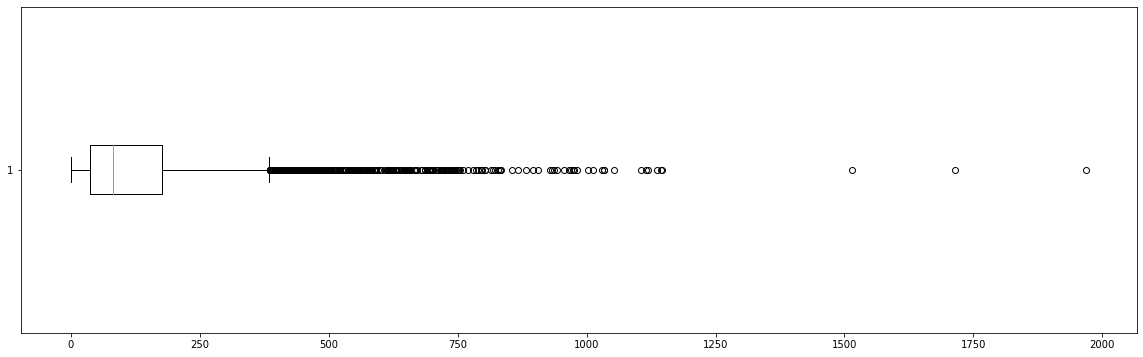

In [46]:
plt.figure(figsize=(20,6))
plt.boxplot(user_length, vert=0)
plt.show()

잘 제거됐습니다.

### 2-6. Train/ Valid/ Test split

In [47]:
# 영화는 최근 본 영화가 마음에 들을수록 그와 비슷한 영화를 보게 될 확률이 높아집니다. 따라서
# 2000년 4월~2001년 4월 까지를 train set, 
#2001년 5월~ 2001년 12월 까지를 Valid set, 
#2002년 1월~ 2003년 2월까지의 데이터를 Test set으로 두겠습니다.

In [70]:
data['Date'].max()

'2003-02-28'

In [49]:
data.groupby('UserId')['Date'].max()

UserId
1       2001-01-06
2       2000-12-31
3       2000-12-31
4       2000-12-31
5       2000-12-31
           ...    
6036    2000-04-26
6037    2000-04-27
6038    2000-04-26
6039    2000-04-26
6040    2001-08-20
Name: Date, Length: 6039, dtype: object

In [71]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

def split_by_month(data: pd.DataFrame, n_months: int):
    final_time = pd.to_datetime(data['Date'].max())
    #print(final_time)
    session_last_time = data.groupby('UserId')['Date'].max()
    tmp = final_time - relativedelta(months = n_months)   # 맨 끝 날짜에서 n개월을 뺍니다
    tmpdate = tmp.strftime('%Y-%m-%d') # string 타입으로 변환
    #print(tmp)
    session_in_train = session_last_time[session_last_time < tmpdate].index
    session_in_test = session_last_time[session_last_time >= tmpdate].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [72]:
train, test = split_by_month(data, n_months=14)
train, valid = split_by_month(train, n_months=8)

cleansing 한 전체 데이터 셋에 대해 다시 나눠주고

In [73]:
#train = pd.concat([yr2000,yr2001], ignore_index=True)
train

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26
999764,6039,912,4,956758029,2000-04-26
999771,6039,922,5,956758029,2000-04-26
999815,6039,1204,5,956758029,2000-04-26


In [74]:
train['Date'].max()

'2001-04-25'

In [75]:
valid

,UserId,ItemId,Rating,Time,Date
2469,19,2527,3,978146700,2000-12-30
2298,19,593,5,978146713,2000-12-30
2432,19,527,3,978146727,2000-12-30
2457,19,1210,4,978146747,2000-12-30
2497,19,2115,3,978146747,2000-12-30
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [76]:
test

,UserId,ItemId,Rating,Time,Date
2522,20,2028,4,978143106,2000-12-30
2516,20,1617,5,978143181,2000-12-30
2515,20,47,5,978143306,2000-12-30
2514,20,3578,5,978143344,2000-12-30
2501,20,3863,3,978143355,2000-12-30
...,...,...,...,...,...
994100,6002,2013,4,1014524679,2002-02-24
993890,6002,2520,4,1014524680,2002-02-24
994045,6002,1387,5,1014524720,2002-02-24
993900,6002,1927,4,1014524758,2002-02-24


In [77]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [78]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 590449
	 Users: 5150
	 Items: 3556
	 First Time : 2000-04-25
	 Last Time : 2001-04-25

* valid Set Stats Info
	 Events: 63883
	 Users: 300
	 Items: 3076
	 First Time : 2000-04-25
	 Last Time : 2001-12-26

* test Set Stats Info
	 Events: 182046
	 Users: 589
	 Items: 3381
	 First Time : 2000-04-27
	 Last Time : 2003-02-28



In [79]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [80]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니 배치의 구성

Session-Parallel Mini Batch를 구현합니다. 여기서는 Session이 아닌 UserID 기반입니다.

우선, 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [81]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.   
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.   
user_idx 변수는 각 세션을 인덱싱한 np.array 입니다.   

In [82]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [83]:
train_dataset.click_offsets

array([     0,     53,    169, ..., 590312, 590330, 590449], dtype=int32)

In [84]:
train_dataset.session_idx

array([   0,    1,    2, ..., 5147, 5148, 5149])

### Session DataLoader

UserDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.   
mask는 후에 RNN Cell State를 초기화 하는데 사용합니다.

In [86]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [87]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [88]:
iter_ex = iter(train_data_loader)

In [89]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 3. 모델 구성

In [90]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [92]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [114]:
class Args:
    def __init__(self, train, valid, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.valid = valid
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)

In [115]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541200    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (256, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [116]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.valid, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [117]:
train_model(model, args)

Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.41]

	 - Recall@20 epoch 1: 0.154260
	 - MRR@20    epoch 1: 0.037941



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.81] 

	 - Recall@20 epoch 2: 0.268278
	 - MRR@20    epoch 2: 0.072229



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.52] 

	 - Recall@20 epoch 3: 0.315006
	 - MRR@20    epoch 3: 0.088449



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.39] 

	 - Recall@20 epoch 4: 0.335569
	 - MRR@20    epoch 4: 0.099502



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.33] 

	 - Recall@20 epoch 5: 0.347214
	 - MRR@20    epoch 5: 0.104668



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.28] 

	 - Recall@20 epoch 6: 0.355100
	 - MRR@20    epoch 6: 0.108516



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.21] 

	 - Recall@20 epoch 7: 0.360186
	 - MRR@20    epoch 7: 0.111499



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.2]  

	 - Recall@20 epoch 8: 0.366377
	 - MRR@20    epoch 8: 0.114641



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.2]  

	 - Recall@20 epoch 9: 0.368883
	 - MRR@20    epoch 9: 0.116369



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.99]

	 - Recall@20 epoch 10: 0.370946
	 - MRR@20    epoch 10: 0.118357



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.03] 

	 - Recall@20 epoch 11: 0.371462
	 - MRR@20    epoch 11: 0.120285



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.03] 

	 - Recall@20 epoch 12: 0.373600
	 - MRR@20    epoch 12: 0.121664



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.03]

	 - Recall@20 epoch 13: 0.373600
	 - MRR@20    epoch 13: 0.121678



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.96]

	 - Recall@20 epoch 14: 0.375074
	 - MRR@20    epoch 14: 0.123016



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.02] 

	 - Recall@20 epoch 15: 0.375074
	 - MRR@20    epoch 15: 0.123269



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.05]

	 - Recall@20 epoch 16: 0.375147
	 - MRR@20    epoch 16: 0.123743



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.04] 

	 - Recall@20 epoch 17: 0.374853
	 - MRR@20    epoch 17: 0.123808



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.05] 

	 - Recall@20 epoch 18: 0.375147
	 - MRR@20    epoch 18: 0.124120



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.02]  

	 - Recall@20 epoch 19: 0.375074
	 - MRR@20    epoch 19: 0.123723



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5]   

	 - Recall@20 epoch 20: 0.373452
	 - MRR@20    epoch 20: 0.123484



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.02]

	 - Recall@20 epoch 21: 0.374337
	 - MRR@20    epoch 21: 0.123682



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.98]

	 - Recall@20 epoch 22: 0.375295
	 - MRR@20    epoch 22: 0.123896



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.94] 

	 - Recall@20 epoch 23: 0.374263
	 - MRR@20    epoch 23: 0.123262



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.95] 

	 - Recall@20 epoch 24: 0.375737
	 - MRR@20    epoch 24: 0.124276



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.04]

	 - Recall@20 epoch 25: 0.375442
	 - MRR@20    epoch 25: 0.123858



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=4.95]

	 - Recall@20 epoch 26: 0.377948
	 - MRR@20    epoch 26: 0.123593



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.94]

	 - Recall@20 epoch 27: 0.375369
	 - MRR@20    epoch 27: 0.123156



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.96]

	 - Recall@20 epoch 28: 0.375369
	 - MRR@20    epoch 28: 0.123373



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.96] 

	 - Recall@20 epoch 29: 0.375516
	 - MRR@20    epoch 29: 0.123349



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.91]

	 - Recall@20 epoch 30: 0.375000
	 - MRR@20    epoch 30: 0.123658



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=4.96]

	 - Recall@20 epoch 31: 0.374853
	 - MRR@20    epoch 31: 0.123691



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.96]

	 - Recall@20 epoch 32: 0.373600
	 - MRR@20    epoch 32: 0.123171



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.97] 

	 - Recall@20 epoch 33: 0.373231
	 - MRR@20    epoch 33: 0.123260



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0508, train_loss=4.97]

	 - Recall@20 epoch 34: 0.375442
	 - MRR@20    epoch 34: 0.123197



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.94] 

	 - Recall@20 epoch 35: 0.375811
	 - MRR@20    epoch 35: 0.123832



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0508, train_loss=4.9] 

	 - Recall@20 epoch 36: 0.374263
	 - MRR@20    epoch 36: 0.122939



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.9] 

	 - Recall@20 epoch 37: 0.375000
	 - MRR@20    epoch 37: 0.123015



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0508, train_loss=4.93]

	 - Recall@20 epoch 38: 0.373452
	 - MRR@20    epoch 38: 0.122773



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.94]

	 - Recall@20 epoch 39: 0.374484
	 - MRR@20    epoch 39: 0.123711



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.082, train_loss=4.92] 

	 - Recall@20 epoch 40: 0.374926
	 - MRR@20    epoch 40: 0.123457



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.84]

	 - Recall@20 epoch 41: 0.372936
	 - MRR@20    epoch 41: 0.123412



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.87]

	 - Recall@20 epoch 42: 0.372789
	 - MRR@20    epoch 42: 0.123053



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.81] 

	 - Recall@20 epoch 43: 0.373452
	 - MRR@20    epoch 43: 0.123233



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0898, train_loss=4.9] 

	 - Recall@20 epoch 44: 0.372052
	 - MRR@20    epoch 44: 0.123224



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.87]

	 - Recall@20 epoch 45: 0.372420
	 - MRR@20    epoch 45: 0.122724



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=4.93]

	 - Recall@20 epoch 46: 0.372642
	 - MRR@20    epoch 46: 0.123042



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.082, train_loss=4.9]  

	 - Recall@20 epoch 47: 0.372273
	 - MRR@20    epoch 47: 0.122144



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.96]

	 - Recall@20 epoch 48: 0.370946
	 - MRR@20    epoch 48: 0.123019



Train:   0%|          | 0/2286 [00:00<?, ?it/s, accuracy=0.0742, train_loss=4.9] 

	 - Recall@20 epoch 49: 0.371683
	 - MRR@20    epoch 49: 0.122956



Evaluation:  21%|██▏       | 53/248 [00:28<01:45,  1.86it/s]

	 - Recall@20 epoch 50: 0.372420
	 - MRR@20    epoch 50: 0.123653



## 5. 모델 테스트

In [118]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  67%|██████▋   | 473/708 [04:39<02:18,  1.69it/s]

	 - Recall@20: 0.281035
	 - MRR@20: 0.086095



## 2번째 모델 - 하이퍼파라미터 변경

In [119]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.4, lr=0.01, epochs=30, k=20)

In [120]:
model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_6 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [121]:
train_model(model, args)

Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.73] 

	 - Recall@20 epoch 1: 0.268793
	 - MRR@20    epoch 1: 0.070223



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.72] 

	 - Recall@20 epoch 2: 0.278646
	 - MRR@20    epoch 2: 0.075249



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.64] 

	 - Recall@20 epoch 3: 0.287720
	 - MRR@20    epoch 3: 0.077141



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.57] 

	 - Recall@20 epoch 4: 0.286619
	 - MRR@20    epoch 4: 0.077746



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.44] 

	 - Recall@20 epoch 5: 0.287640
	 - MRR@20    epoch 5: 0.077865



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.5]  

	 - Recall@20 epoch 6: 0.288848
	 - MRR@20    epoch 6: 0.078714



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.52] 

	 - Recall@20 epoch 7: 0.289787
	 - MRR@20    epoch 7: 0.078253



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.64] 

	 - Recall@20 epoch 8: 0.289304
	 - MRR@20    epoch 8: 0.078372



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.53] 

	 - Recall@20 epoch 9: 0.289761
	 - MRR@20    epoch 9: 0.078981



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.42] 

	 - Recall@20 epoch 10: 0.292848
	 - MRR@20    epoch 10: 0.079089



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.59]

	 - Recall@20 epoch 11: 0.287908
	 - MRR@20    epoch 11: 0.078455



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.47] 

	 - Recall@20 epoch 12: 0.289385
	 - MRR@20    epoch 12: 0.078242



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.43] 

	 - Recall@20 epoch 13: 0.290002
	 - MRR@20    epoch 13: 0.079031



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.58]

	 - Recall@20 epoch 14: 0.289036
	 - MRR@20    epoch 14: 0.078710



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.45] 

	 - Recall@20 epoch 15: 0.288740
	 - MRR@20    epoch 15: 0.077749



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.72]

	 - Recall@20 epoch 16: 0.289062
	 - MRR@20    epoch 16: 0.078099



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.51] 

	 - Recall@20 epoch 17: 0.292311
	 - MRR@20    epoch 17: 0.078366



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.66] 

	 - Recall@20 epoch 18: 0.289492
	 - MRR@20    epoch 18: 0.078120



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.5] 

	 - Recall@20 epoch 19: 0.288364
	 - MRR@20    epoch 19: 0.077231



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.59] 

	 - Recall@20 epoch 20: 0.288150
	 - MRR@20    epoch 20: 0.077045



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.63] 

	 - Recall@20 epoch 21: 0.288472
	 - MRR@20    epoch 21: 0.078046



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.48] 

	 - Recall@20 epoch 22: 0.287237
	 - MRR@20    epoch 22: 0.077868



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.47] 

	 - Recall@20 epoch 23: 0.289814
	 - MRR@20    epoch 23: 0.078609



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.66] 

	 - Recall@20 epoch 24: 0.286727
	 - MRR@20    epoch 24: 0.076564



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.65] 

	 - Recall@20 epoch 25: 0.288230
	 - MRR@20    epoch 25: 0.077236



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.68] 

	 - Recall@20 epoch 26: 0.284015
	 - MRR@20    epoch 26: 0.077237



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.7]  

	 - Recall@20 epoch 27: 0.290512
	 - MRR@20    epoch 27: 0.077826



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.5] 

	 - Recall@20 epoch 28: 0.288740
	 - MRR@20    epoch 28: 0.077743



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.52]

	 - Recall@20 epoch 29: 0.286646
	 - MRR@20    epoch 29: 0.076777



Evaluation:  59%|█████▊    | 291/496 [01:27<01:01,  3.32it/s]

	 - Recall@20 epoch 30: 0.286297
	 - MRR@20    epoch 30: 0.077670



In [122]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [06:07<01:13,  3.21it/s]

	 - Recall@20: 0.236088
	 - MRR@20: 0.063465



## 3번째 모델 - 모델 구조 (loss 종류) 변경

loss를 pairwise ranking-based loss 중 하나인 mse를 선택해서 돌려보려합니다.

In [139]:
from tensorflow.keras.losses import mse

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=mse, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [140]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [141]:
model = create_model(args)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(128, 1, 3556)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    541200    
_________________________________________________________________
dropout_12 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_12 (Dense)             (128, 3556)               181356    
Total params: 722,556
Trainable params: 722,556
Non-trainable params: 0
_________________________________________________________________


In [142]:
train_model(model, args)

Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0, train_loss=0.000281]      

	 - Recall@20 epoch 1: 0.067467
	 - MRR@20    epoch 1: 0.014065



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 2: 0.069829
	 - MRR@20    epoch 2: 0.014298



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 3: 0.070098
	 - MRR@20    epoch 3: 0.014217



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 4: 0.069883
	 - MRR@20    epoch 4: 0.014250



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 5: 0.070232
	 - MRR@20    epoch 5: 0.014277



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 6: 0.070366
	 - MRR@20    epoch 6: 0.014223



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0, train_loss=0.000281]      

	 - Recall@20 epoch 7: 0.070312
	 - MRR@20    epoch 7: 0.014169



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 8: 0.070205
	 - MRR@20    epoch 8: 0.014173



Train:   0%|          | 0/4572 [00:00<?, ?it/s, accuracy=0.0156, train_loss=0.000281] 

	 - Recall@20 epoch 9: 0.070339
	 - MRR@20    epoch 9: 0.014152



Evaluation:  59%|█████▊    | 291/496 [01:37<01:08,  2.99it/s]

	 - Recall@20 epoch 10: 0.070420
	 - MRR@20    epoch 10: 0.014143



In [143]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  83%|████████▎ | 1181/1417 [06:40<01:20,  2.95it/s]

	 - Recall@20: 0.047748
	 - MRR@20: 0.009238



loss를 바꿨더니 성능이 훨씬 안좋게 나왔습니다..

## 결론 및 회고

이번 프로젝트에서는 세션 기반의 추천 시스템을 만들어 보았습니다. 
데이터 전처리 과정에서 평점이 3점 이하인 데이터를 제거해주었고, session(UserID) length가 2000 이상인 데이터는 제거해주었습니다.   
모델은 노드에 나와있었던 세션 기반 추천 모델 관련한 논문에서 사용한 구조(GRU)를 따랐습니다.   
이번 프로젝트를 하면서 알게 된 사실은 다음과 같습니다.

* 에폭의 변경은 그렇게 큰 영향을 주지 못했다.
* cross-entropy loss 보다는 pairwise ranking based loss를 사용하는 것이 더 성능이 좋다고 한다.
* 사실 loss function으로는 BPR loss를 선택하는 것이 최선이지만 함수를 불러오려면 따로 구현해야한다.
* 추천 모델 성능 평가를 위한 지표로는 Recall과 MRR을 사용하는 것이 일반적이다.
* recall을 구할 때는 k 값을 점점 크게 주면서 값을 비교하는 것이 좋다.

또한 Precision보다 Recall 지표를 비교해보면   
* precision = 실제로 추천한 영화 중 사용자가 선호하는 영화를 얼마나 추천해주었는가
* recall = 사용자가 선호하는 영화를 얼마나 맞췄는가

인데, Recall 지표를 사용하는 이유는 사용자 입장에서 __좋아하는 영화를 추천 안해주는 것 보다는 싫어하는 영화를 계속 추천해주는게 더 싫어서__ 가 아닐까 싶습니다.

결과적으로 총 3번의 다양한 모델을 돌려보았더니    

첫번째 모델은 __Recall@20: 0.281035, MRR@20: 0.086095__      
두번째 모델은 __Recall@20: 0.236088, MRR@20: 0.063465__    
세번째 모델은      

라는 결과를 얻었습니다. 알게된 사실과는 다르게 loss를 바꿨더니 성능이 매우 안좋게 나오기도 했습니다..   
세 모델 모두 recall값이 크지 않아 좋은 모델 결과를 얻었다고 할 수는 없지만, 프로젝트 과정에서 여러 논문도 참고하고 평가 지표에 대해 고민도 하고 많이 배울 수 있었습니다. 